In [1]:
import numpy as np;
import pandas as pd;
import pandas_datareader.data as web;
import yfinance as yf;
import random;
import matplotlib.pyplot as plt;
import datetime;
import math;

In [2]:
b3_tickers_list = list(pd.read_csv('acoes-listadas-b3.csv').Ticker);
b3_tickers_list = [ticker + '.SA' for ticker in b3_tickers_list];
start_date = '2015-01-01';
initial_balance_per_asset = 10000;
b3_df = yf.download(b3_tickers_list, start=start_date);
b3_df.dropna(axis=1, inplace=True);

[*********************100%%**********************]  402 of 402 completed

4 Failed downloads:
['PINE11.SA', 'BIOM11.SA', 'AMAR11.SA', 'AZEV11.SA']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


In [3]:
next_date = datetime.datetime.strptime(start_date, '%Y-%m-%d') + datetime.timedelta(days=1);
next_date_close_b3_df = b3_df['Adj Close'].loc[str(next_date.date()), [b3_df['Adj Close'].loc[str(next_date.date()), column] < 10000 for column in b3_df['Adj Close'].columns]];
random_assets = random.sample(list(next_date_close_b3_df.index), 5);

price_per_asset = next_date_close_b3_df[random_assets];
volume_acquired = [int(initial_balance_per_asset / price_per_asset[column]) for column in random_assets];
total_balance_per_asset = [round(volume_acquired[pos] * price_per_asset[column], 2) for column, pos in zip(random_assets, range(0, 5))];
print(price_per_asset, volume_acquired, total_balance_per_asset);

portfolio = pd.DataFrame(
    data=[price_per_asset.values, volume_acquired, total_balance_per_asset],
    columns=random_assets
);
portfolio['Indexes'] = ['unit_price', 'volume_acquired', 'total_balance'];
portfolio.set_index('Indexes', inplace=True);
portfolio

Ticker
YDUQ3.SA    16.091354
BBSE3.SA    14.295558
PINE3.SA     7.721864
CSRN6.SA     3.087765
FESA4.SA     1.067747
Name: 2015-01-02 00:00:00, dtype: float64 [621, 699, 1295, 3238, 9365] [9992.73, 9992.6, 9999.81, 9998.18, 9999.45]


,YDUQ3.SA,BBSE3.SA,PINE3.SA,CSRN6.SA,FESA4.SA
Indexes,,,,,
unit_price,16.091354,14.295558,7.721864,3.087765,1.067747
volume_acquired,621.000000,699.000000,1295.000000,3238.000000,9365.000000
total_balance,9992.730000,9992.600000,9999.810000,9998.180000,9999.450000


In [4]:
portfolio_progression = pd.DataFrame();

for asset, pos in zip(random_assets, range(0, 5)):
    portfolio_progression[asset] = b3_df['Adj Close'].loc[:, asset] * volume_acquired[pos];

print(portfolio_progression)
ibvsp = yf.download(['^BVSP'], start=start_date);

equivalent_ibvsp = (ibvsp['Adj Close'] / ibvsp['Adj Close'][str(next_date.date())]) * portfolio.loc['total_balance', :].sum()
equivalent_ibvsp

               YDUQ3.SA      BBSE3.SA     PINE3.SA      CSRN6.SA      FESA4.SA
Date                                                                          
2015-01-02  9992.731064   9992.595025  9999.814169   9998.183000   9999.448393
2015-01-05  9394.528433   9692.982742  9999.814169   9998.183000   9513.190272
2015-01-06  8846.175133  10104.540244  9999.814169   9998.183000   9351.108139
2015-01-07  8569.731420   9943.211938  9999.814169   9998.183000   9937.106664
2015-01-08  8837.111026   9913.576753  9999.814169   9998.183000   9962.043579
...                 ...           ...          ...           ...           ...
2024-08-15  6272.100237  25106.924137  7329.699802  53945.079506  78104.101429
2024-08-16  6085.800118  25093.466446  7174.299951  55046.000000  77261.250000
2024-08-19  6588.809787  25198.949467  7290.850148  54236.500000  79789.804287
2024-08-20  6396.300118  25198.949467  7368.550074  48570.000000  79883.447499
2024-08-21  6303.149763  25212.929787  7575.749876  

[*********************100%%**********************]  1 of 1 completed


Date
2015-01-02     49982.770000
2015-01-05     48957.603935
2015-01-06     49456.277679
2015-01-07     50962.602088
2015-01-08     51457.154562
                  ...      
2024-08-15    138220.204152
2024-08-16    138014.140621
2024-08-19    139894.470338
2024-08-20    140212.838493
2024-08-21    140601.268249
Name: Adj Close, Length: 2390, dtype: float64

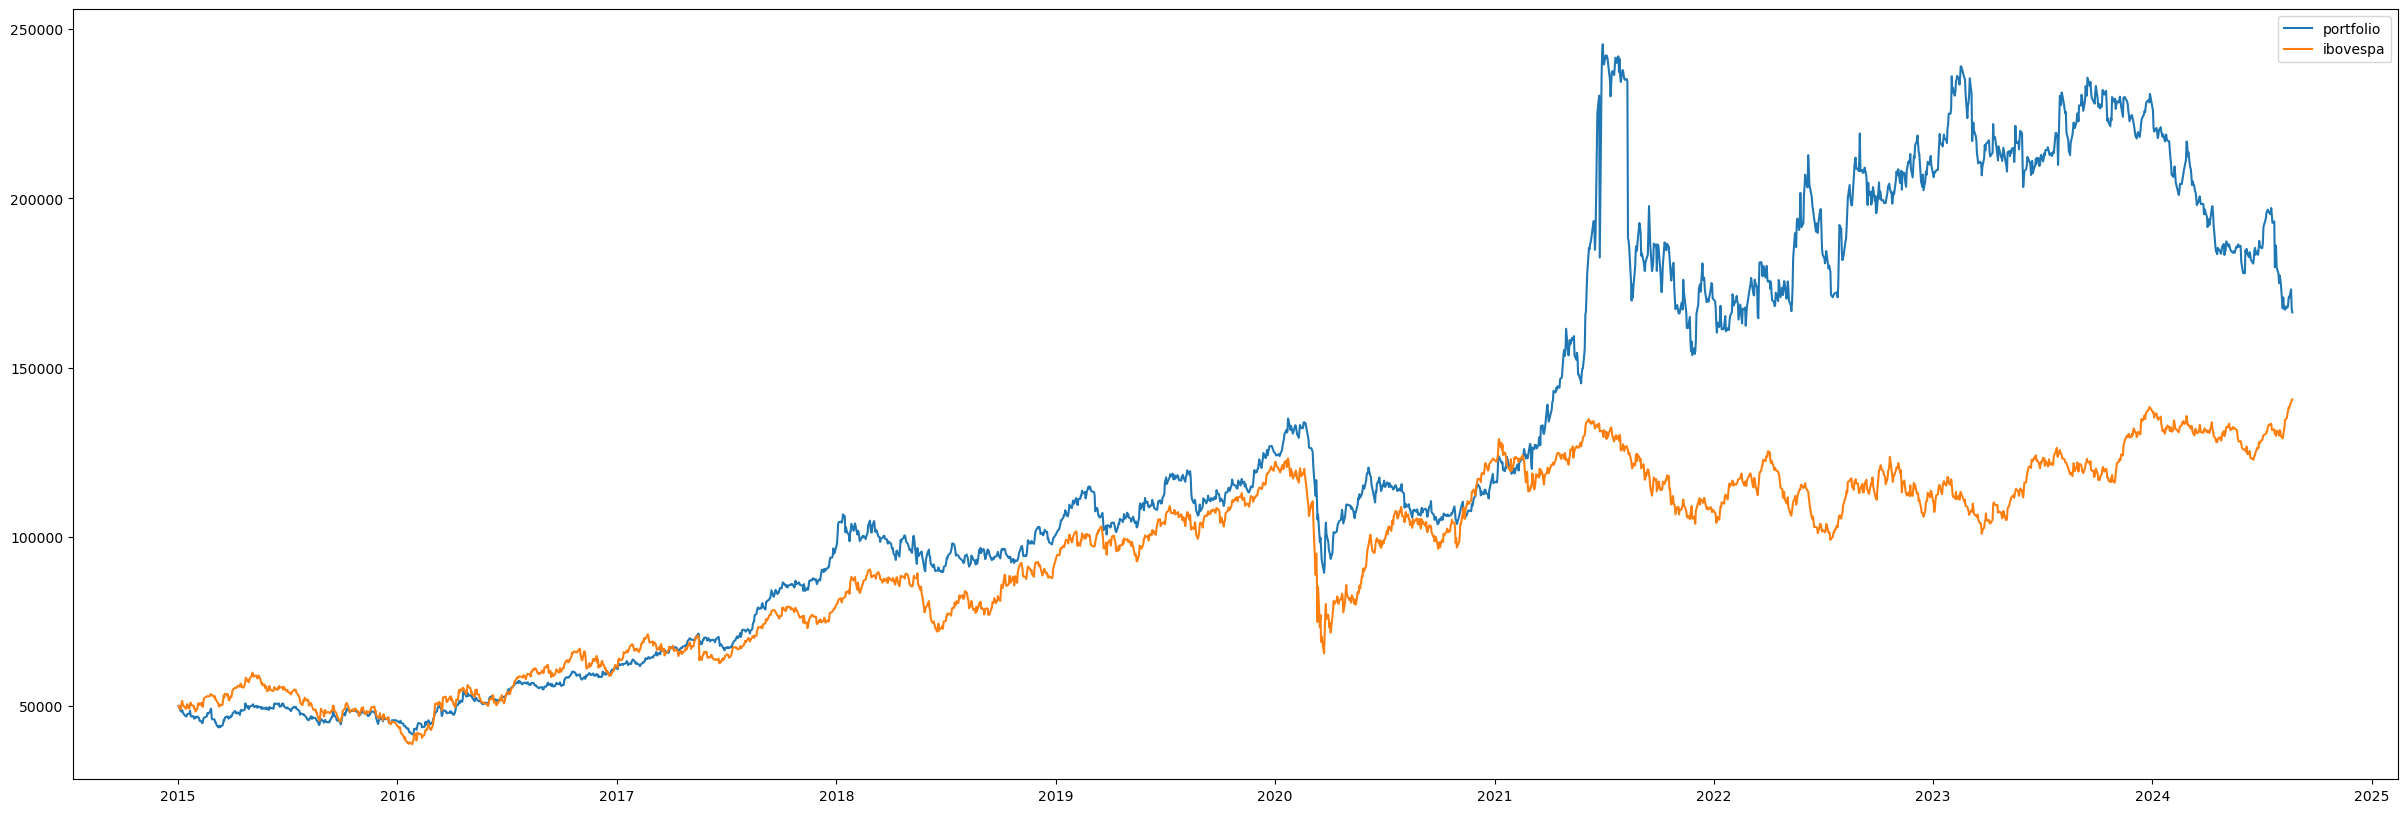

In [5]:
total_portfolio_progression = [];
for row in portfolio_progression.iterrows():
    total_portfolio_progression.append(sum(row[1]));

total_portfolio_progression = pd.Series(total_portfolio_progression, index=portfolio_progression.index);

plt.figure(figsize=(30, 10));
plt.plot(total_portfolio_progression, label='portfolio');
plt.plot(equivalent_ibvsp, label='ibovespa');
plt.legend();

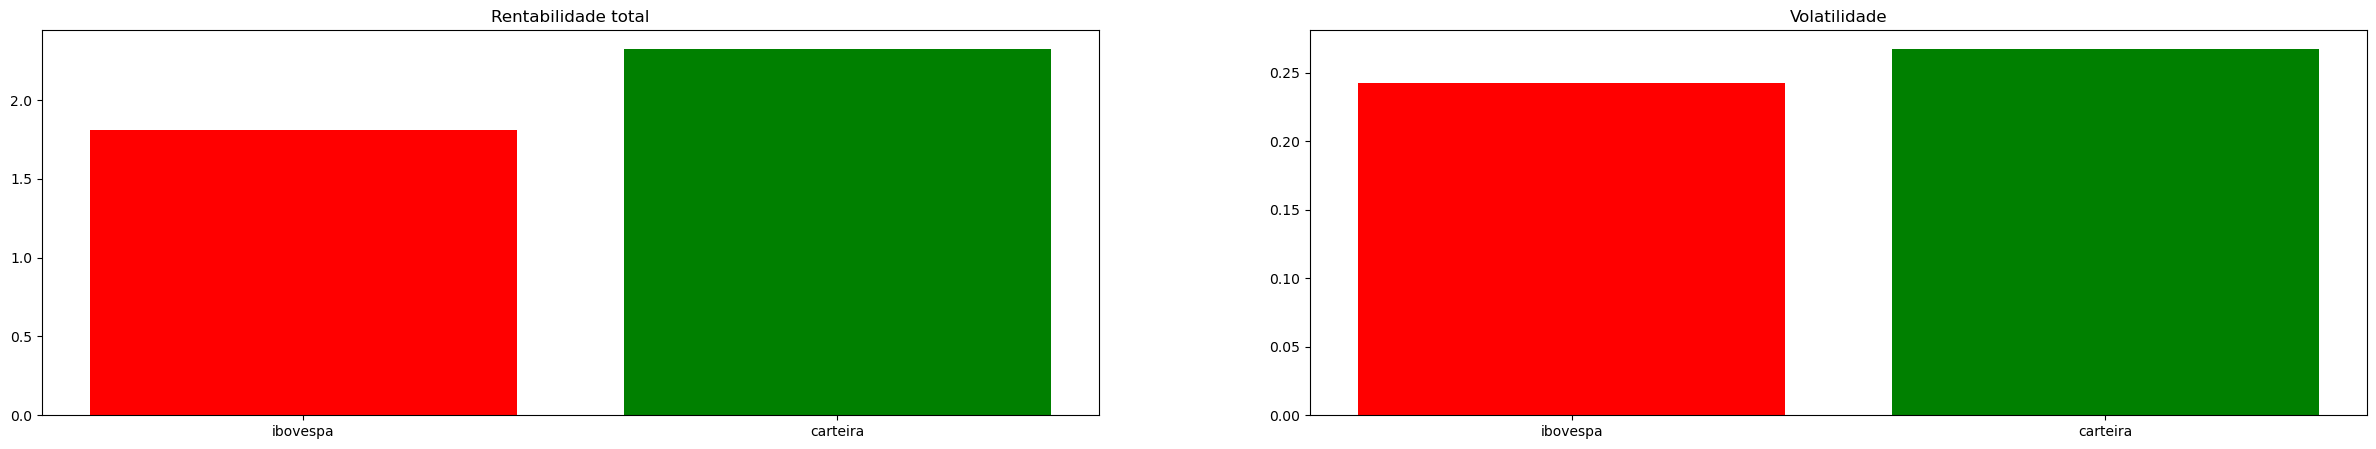

In [6]:
gain_portfolio = (total_portfolio_progression.iloc[-1] - total_portfolio_progression.iloc[0]) / total_portfolio_progression.iloc[0];
gain_ibvsp = (equivalent_ibvsp.iloc[-1] - equivalent_ibvsp.iloc[0]) / equivalent_ibvsp.iloc[0];

daily_profit_portfolio = np.array([]);
for pos in range(1, len(total_portfolio_progression)):
    daily_profit_portfolio = np.append(daily_profit_portfolio, (total_portfolio_progression.iloc[pos] - total_portfolio_progression.iloc[pos - 1]) / total_portfolio_progression.iloc[pos - 1]);

daily_profit_ibvsp = np.array([]);
for pos in range(1, len(equivalent_ibvsp)):
    daily_profit_ibvsp = np.append(daily_profit_ibvsp, (equivalent_ibvsp.iloc[pos] - equivalent_ibvsp.iloc[pos - 1]) / equivalent_ibvsp.iloc[pos - 1]);

portfolio_volatility = np.std(daily_profit_portfolio) * math.sqrt(252);
ibvsp_volatility = np.std(daily_profit_ibvsp) * math.sqrt(252);

fig, ax = plt.subplots(1, 2, figsize=(30, 5));

ax[0].bar(['ibovespa', 'carteira'], [gain_ibvsp, gain_portfolio], color=['r', 'g']);
ax[0].set_title('Rentabilidade total');

ax[1].bar(['ibovespa', 'carteira'], [ibvsp_volatility, portfolio_volatility], color=['r', 'g']);
ax[1].set_title('Volatilidade');

plt.show();